In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

rcParams['figure.figsize'] = (8,6)
warnings.filterwarnings('ignore')

In [107]:
df = pd.read_csv('toughestsport.csv')
df_copy = df.copy()

In [108]:
df.head()

,SPORT,Endurance,Strength,Power,Speed,Agility,Flexibility,Nerve,Durability,Hand-eye coordination,Analytical Aptitude,Total,Rank
0,Boxing,8.63,8.13,8.63,6.38,6.25,4.38,8.88,8.50,7.00,5.63,72.375,1
1,Ice Hockey,7.25,7.13,7.88,7.75,7.63,4.88,6.00,8.25,7.50,7.50,71.750,2
2,Football,5.38,8.63,8.13,7.13,6.38,4.38,7.25,8.50,5.50,7.13,68.375,3
3,Basketball,7.38,6.25,6.50,7.25,8.13,5.63,4.13,7.75,7.50,7.38,67.875,4
4,Wrestling,6.63,8.38,7.13,5.13,6.38,7.50,5.00,6.75,4.25,6.38,63.500,5


In [109]:
metrics_columns = [
    'Endurance',
    'Strength',
    'Power',
    'Speed',
    'Agility',
    'Flexibility',
    'Nerve',
    'Durability',
    'Hand-eye coordination',
    'Analytical Aptitude',
    'Total',
    'Rank']

#### Using correlation matrix we want to see the connection of the metrics columns to each other

In [110]:
corr_matrix = df[metrics_columns].corr()

In [111]:
corr_matrix.shape

(12, 12)

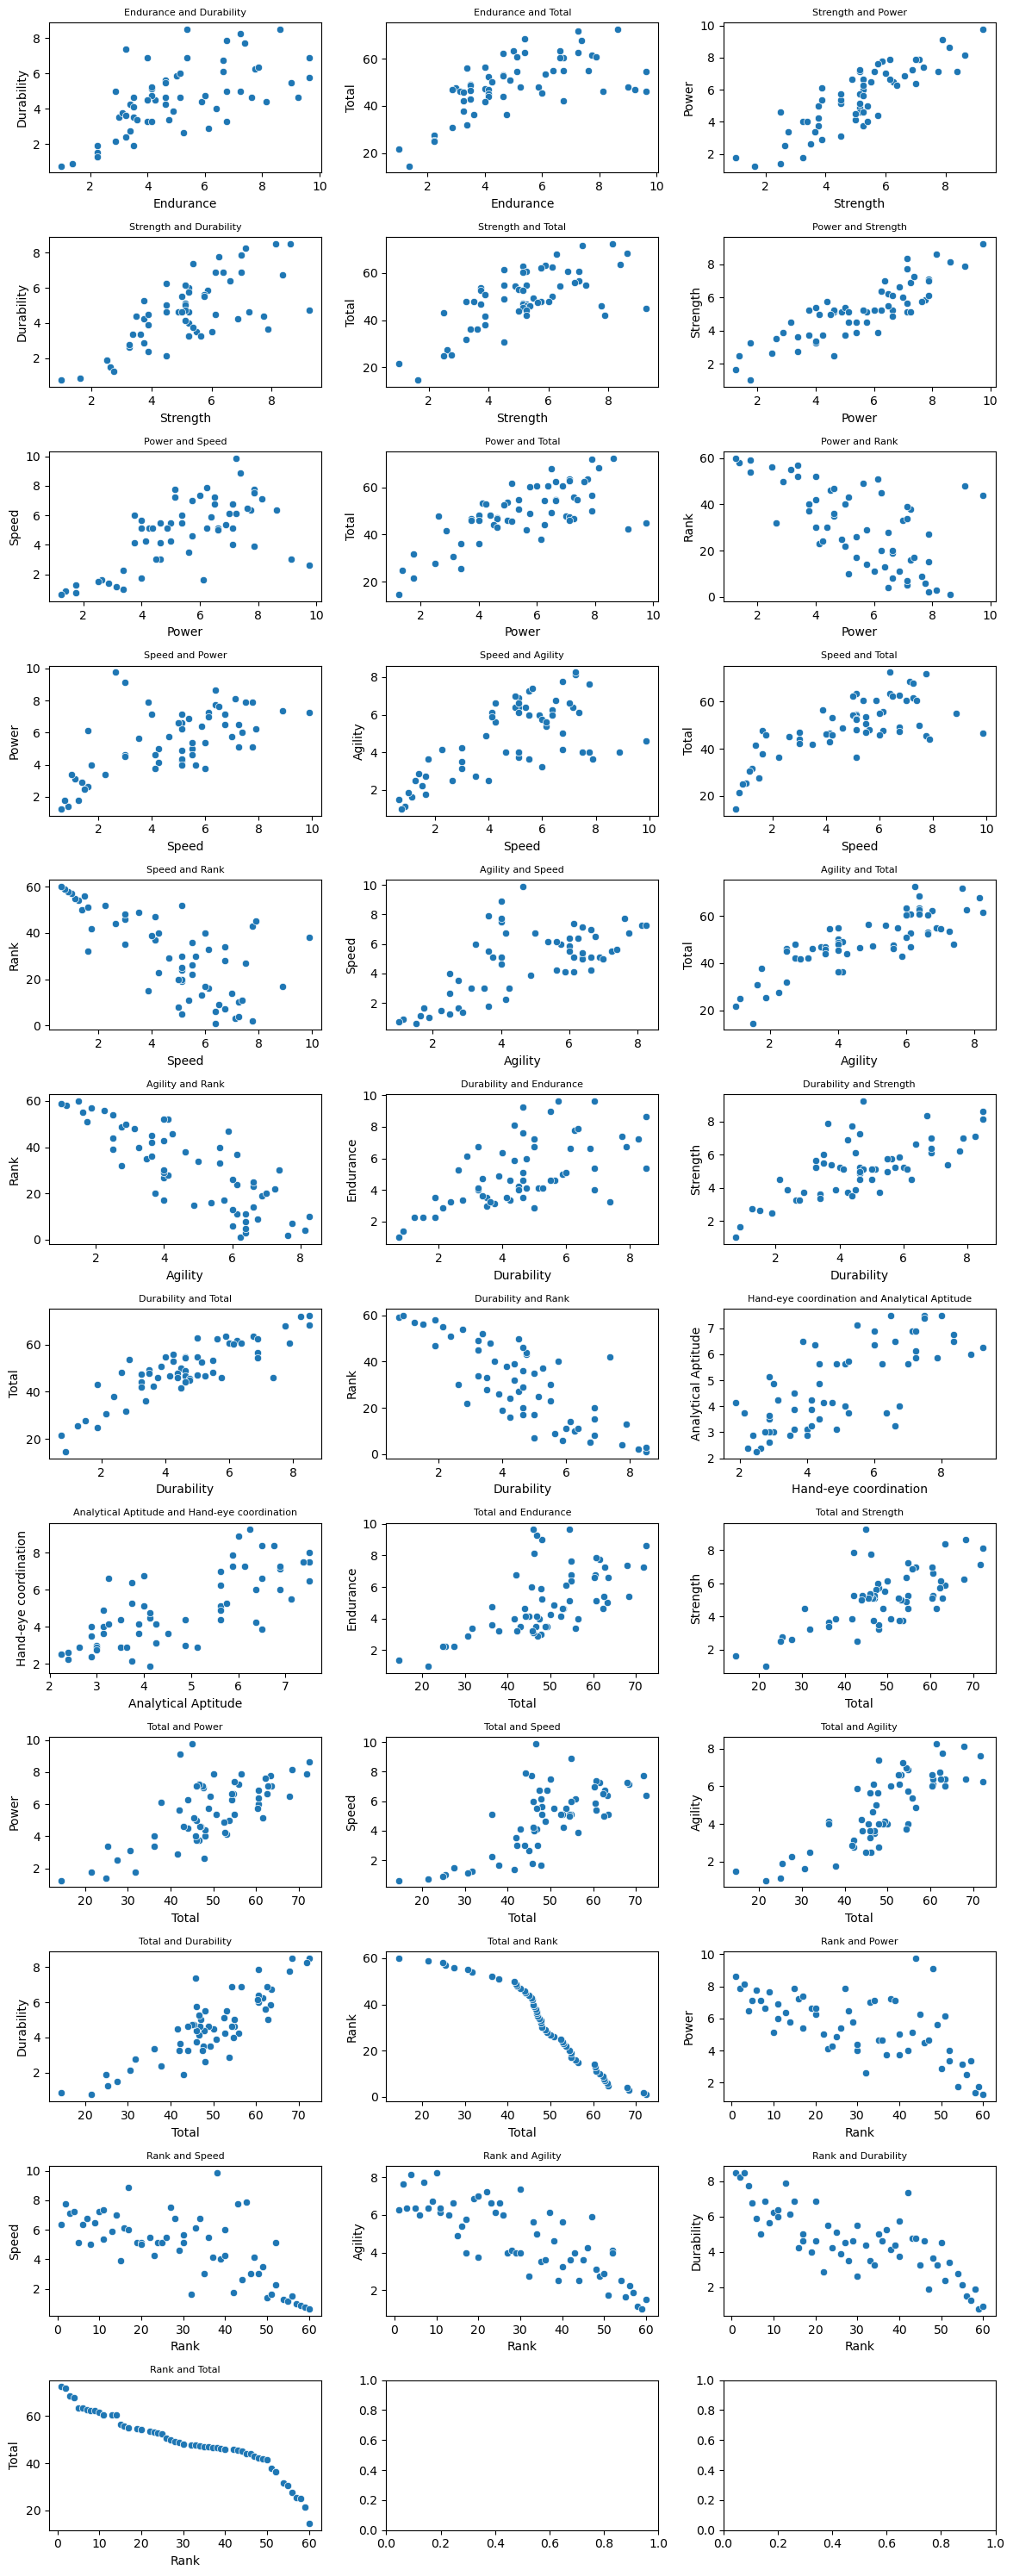

In [112]:
corr_pairs = []
checked = set()
for col_1 in metrics_columns:
    for col_2 in metrics_columns:
        if col_1 != col_2 and (col_1, col_2) not in checked and abs(corr_matrix.loc[col_1, col_2]) > 0.6:
            corr_pairs.append((col_1, col_2))
            checked.add((col_1, col_2))

# Create subplots
num_pairs = len(corr_pairs)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_pairs + num_cols - 1) // num_cols  # Number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,30))

for i, pair in enumerate(corr_pairs):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    sns.scatterplot(data=df, x=pair[0], y=pair[1], ax=ax)
    ax.set_title(f'{pair[0]} and {pair[1]}', fontsize=8)


plt.tight_layout()
plt.show()

#### We plot the distribution of data to get some insight from the visualisation

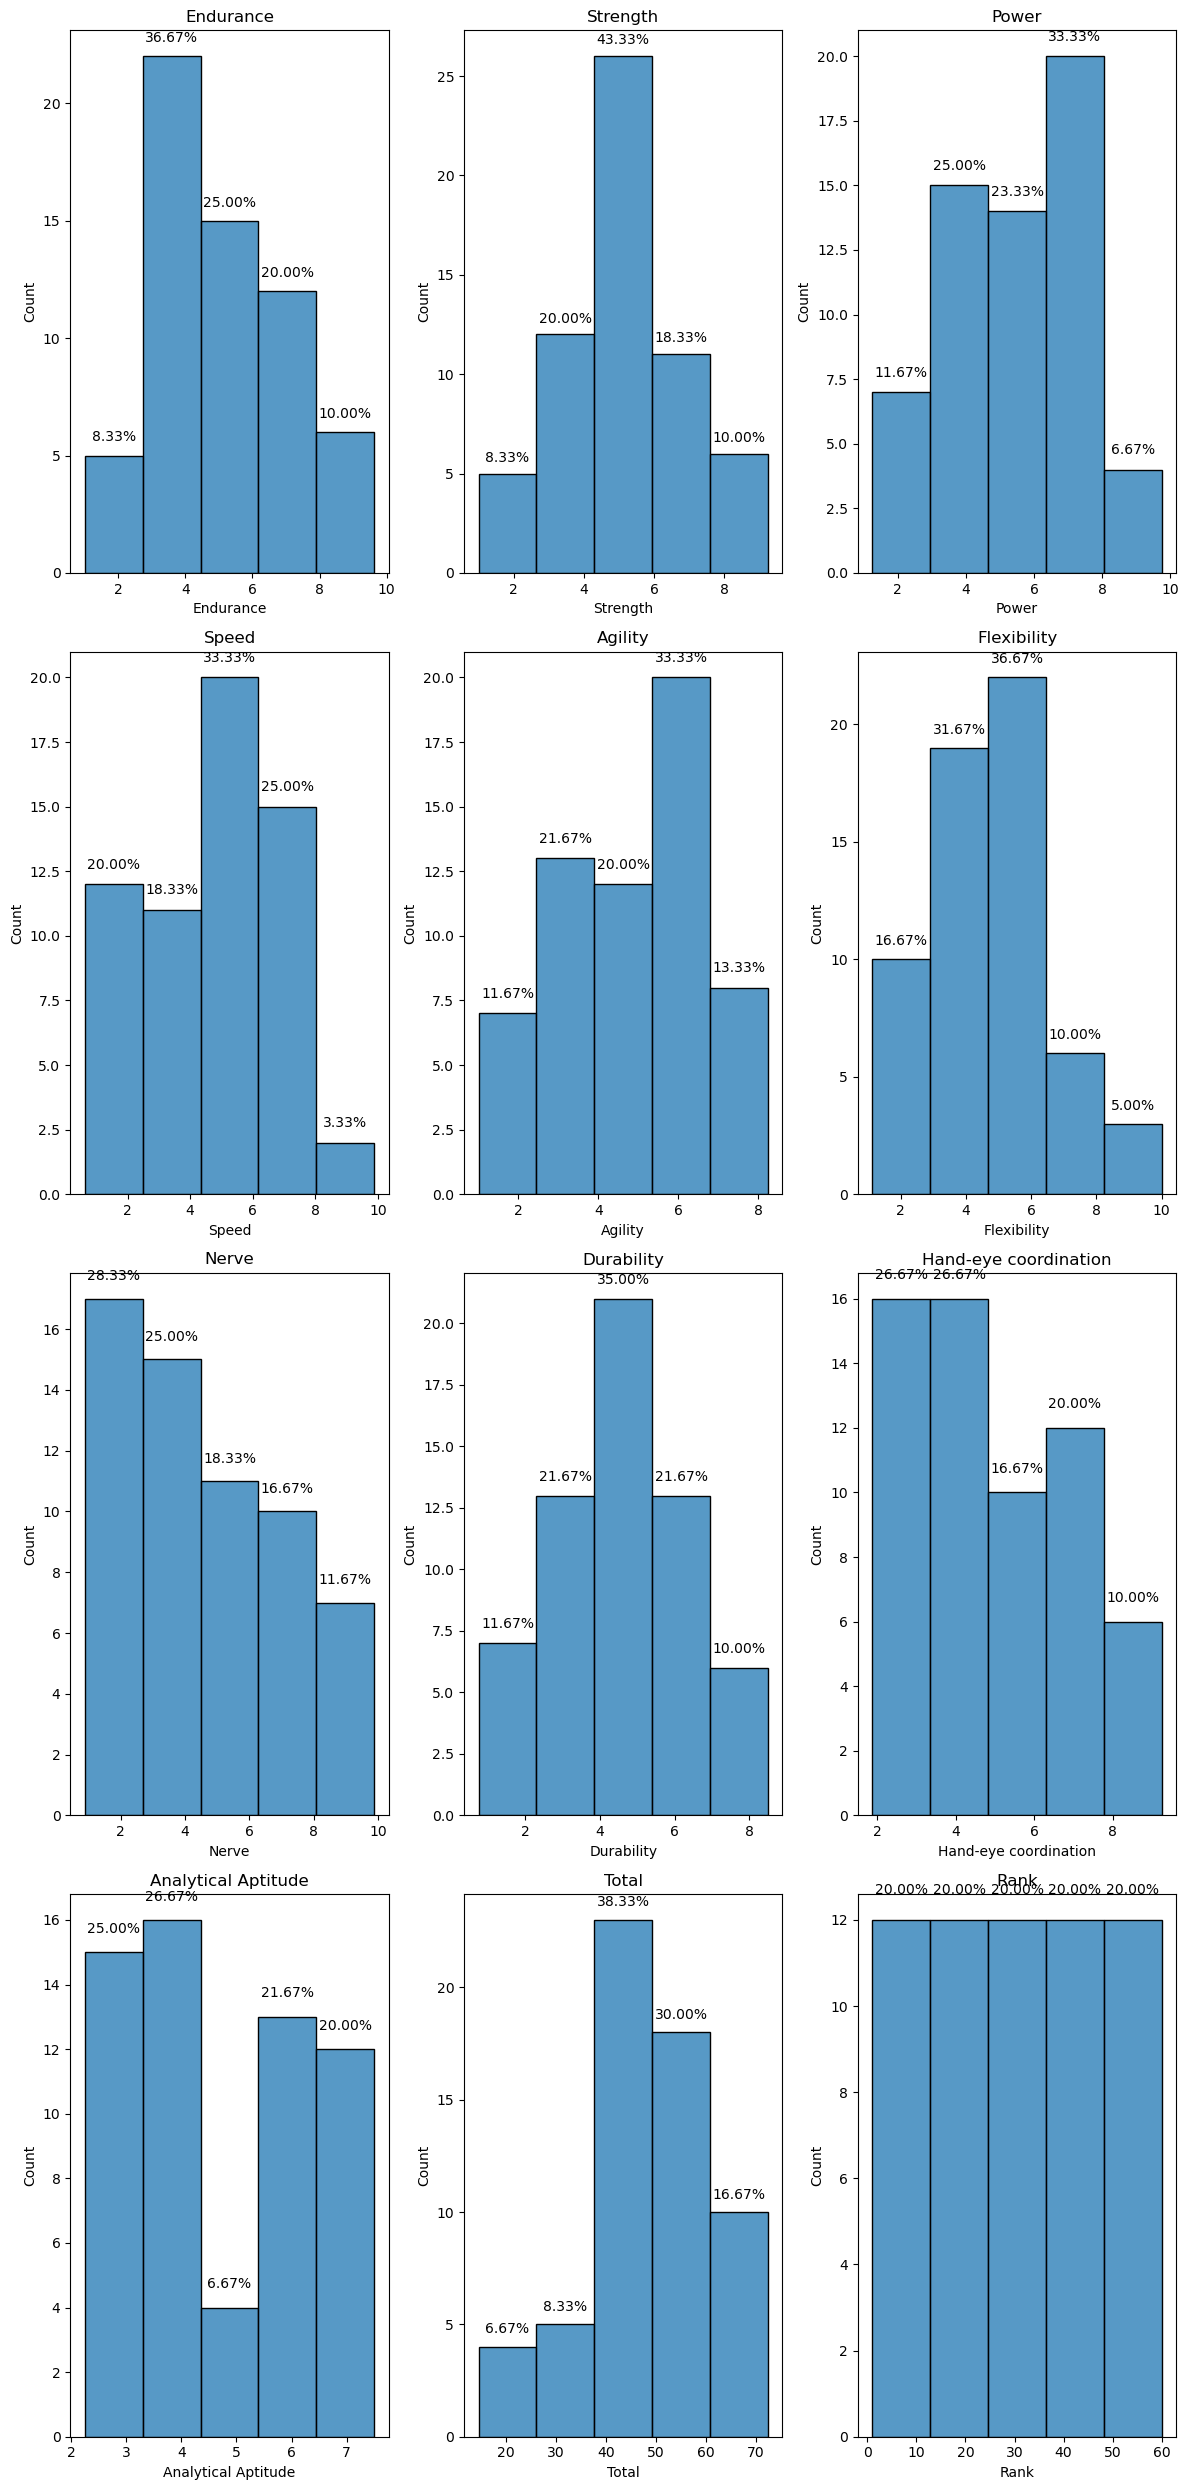

In [113]:
# Histograms for each column
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,25))

for i, col in enumerate(metrics_columns):
    row, col_num = divmod(i, 3)
    sns.histplot(df[col], bins=5, kde=False, ax=axes[row, col_num])
    axes[row, col_num].set_title(col)
    
    # percentage
    total = len(df[col])
    for p in axes[row, col_num].patches:
        height = p.get_height()
        axes[row, col_num].text(p.get_x() + p.get_width() / 2.,
                                height + 0.01 * total,
                                '{:.2%}'.format(height / total),
                                ha="center")

plt.tight_layout()
plt.show()

#### Data preprocessing part to make data raedy for clustering

In [114]:
df.columns

Index(['SPORT', 'Endurance', 'Strength', 'Power', 'Speed', 'Agility',
       'Flexibility', 'Nerve', 'Durability', 'Hand-eye coordination',
       'Analytical Aptitude', 'Total', 'Rank'],
      dtype='object')

In [115]:
df_copy.drop(columns=['SPORT', 'Rank','Total' ], inplace=True)

In [116]:
df_copy.isnull().sum()

Endurance                0
Strength                 0
Power                    0
Speed                    0
Agility                  0
Flexibility              0
Nerve                    0
Durability               0
Hand-eye coordination    0
Analytical Aptitude      0
dtype: int64

In [117]:
df_copy = np.log(df_copy + 0.1)

### We use distortion score or Elbow Method to find the optimal number of K (clusters)

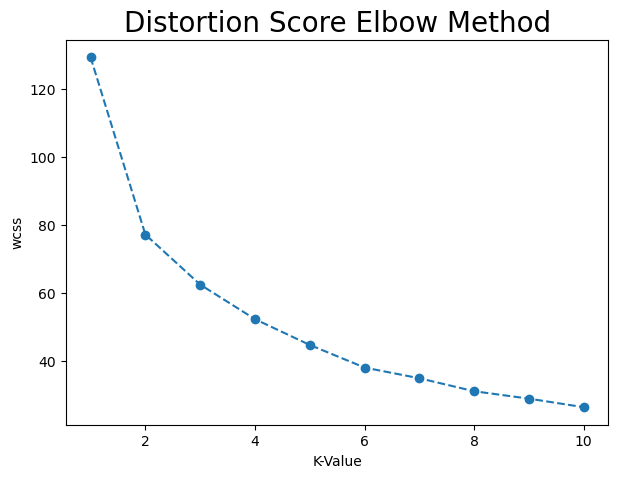

In [118]:
rcParams['figure.figsize'] = (7, 5);
wcss= []
for i in range(1,11): 
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    km.fit(df_copy)
    wcss.append(km.inertia_)
    
plt.plot(range(1,11),wcss, marker='o', linestyle='--')
plt.title('Distortion Score Elbow Method', fontsize =20)
plt.xlabel('K-Value')
plt.ylabel('wcss')
plt.show()

### We reduce the dimension of the data set to 2 for visualizatio

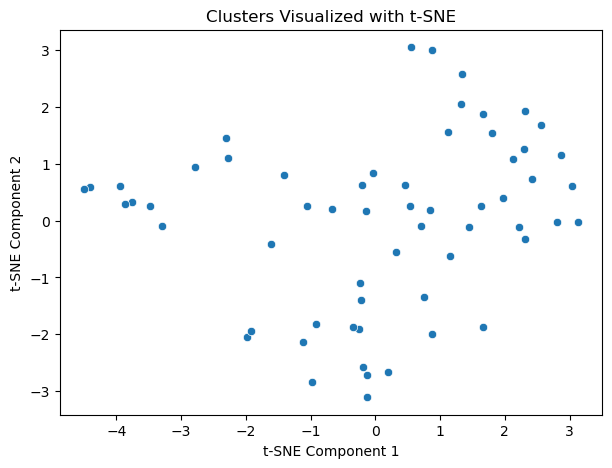

In [119]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=0.1 ,n_iter=2000)
X_tsne = tsne.fit_transform(df_copy)

# Add the cluster information to the reduced data
df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE Component 1', 't-SNE Component 2'])

# Plotting
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', data=df_tsne)
plt.title('Clusters Visualized with t-SNE')
plt.show()

In [120]:
class K_means:
    def __init__(self, K):
        self.K = K
        self.centroids = None

    def findClosestCentroids(self, X):
        m, _ = X.shape
        closest_centroids = np.zeros(m, dtype=int)

        for i in range(m):
            distances = np.linalg.norm(X.iloc[i].values - self.centroids, axis=1)
            closest_centroids[i] = np.argmin(distances)

        return closest_centroids

    def computeCentroids(self, X, idx):
        centroids = X.groupby(idx).mean().values

        return centroids

    def kMeansInitCentroids(self, X):
        idx = np.random.choice(X.index, self.K, replace=False)
        centroids = X.loc[idx].values

        return centroids

    def KMeans_alg(self, X, initial_centroids=None):
        if initial_centroids is None:
            self.centroids = self.kMeansInitCentroids(X)
        else:
            self.centroids = initial_centroids
        
        idx = self.findClosestCentroids(X)
        self.centroids = self.computeCentroids(X, idx)

        return self.centroids, idx

    def fit_predict(self, X):
        return self.findClosestCentroids(X)

### We cluster our dataset to 6 which based on the Elbow Method is the most optimal one

In [121]:
# Number of clusters (K)
n_clusters = 6

# Instantiate the KMeans model
kmeans_amgad = K_means(n_clusters)

# KMeans
centroids, idx = kmeans_amgad.KMeans_alg(df_copy)

# fit
predictions = kmeans_amgad.fit_predict(df_copy)

# Instantiate the KMeans model
kmeans = KMeans(n_clusters=n_clusters )

# Fit the model to the scaled data
kmeans.fit(df_copy)

KMeans(n_clusters=6)

### We visualize the final result in 2d graph

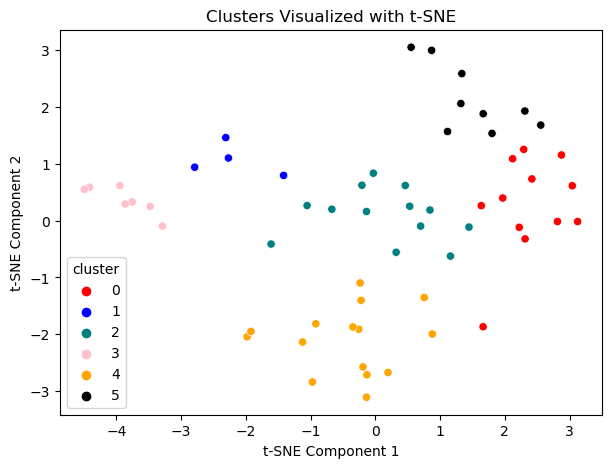

In [127]:
# Add the cluster information to the reduced data
df_tsne['cluster'] = kmeans.labels_

# Plotting
colors = ['red', 'blue', 'teal', 'pink', 'orange', 'black']
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='cluster', data=df_tsne, palette=colors)
plt.title('Clusters Visualized with t-SNE')
plt.show()